In [6]:

# import the necessary libraries: 

import kagglehub
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

/Users/cholponzhakshylykova/Desktop/SDS/SDS-CP027-watt-wise/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# EDA

In [7]:
#------------ get the data -------------

# Download latest version
path = kagglehub.dataset_download("mrsimple07/energy-consumption-prediction")

print("Path to dataset files:", path)

#check the directory
print(os.listdir(path))

data = pd.read_csv(os.path.join(path, "Energy_consumption.csv"))

Path to dataset files: /Users/cholponzhakshylykova/.cache/kagglehub/datasets/mrsimple07/energy-consumption-prediction/versions/1
['Energy_consumption.csv']


In [8]:
data.head()

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


In [9]:


data.head(10)


data.head(10)
'''Same dates are asigned as a holiday and non-holiday, therefore I will drop the col [Holiday] '''


data.drop(["Holiday"], axis = 1, inplace=True)
print(data.columns)


#convert the "Timestamp" column to datetime
#The to_datetime() function is used to convert argument to datetime.

data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data.describe()
data.info()
'''
DatetimeIndex: 1000 entries, 2022-01-01 00:00:00 to 2022-02-11 15:00:00
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperature        1000 non-null   float64
 1   Humidity           1000 non-null   float64
 2   SquareFootage      1000 non-null   float64
 3   Occupancy          1000 non-null   int64  
 4   HVACUsage          1000 non-null   object 
 5   LightingUsage      1000 non-null   object 
 6   RenewableEnergy    1000 non-null   float64
 7   DayOfWeek          1000 non-null   object 
 8   Holiday            1000 non-null   object 
 9   EnergyConsumption  1000 non-null   float64
dtypes: float64(5), int64(1), object(4)
'''

#set timestamp as index
data_date_indexed = data.set_index("Timestamp", inplace=False) #keep the indexed timestamp as a column

print(len(data.columns))
'''10 columns'''


#find the initial and the end date

print(f"Initial date: {data_date_indexed.index.min()}")
print(f"End date: {data_date_indexed.index.max()}")

#since the data is all synthetic it is okay to experiment with all the possible ways to analyze the data. 


Index(['Timestamp', 'Temperature', 'Humidity', 'SquareFootage', 'Occupancy',
       'HVACUsage', 'LightingUsage', 'RenewableEnergy', 'DayOfWeek',
       'EnergyConsumption'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Timestamp          1000 non-null   datetime64[ns]
 1   Temperature        1000 non-null   float64       
 2   Humidity           1000 non-null   float64       
 3   SquareFootage      1000 non-null   float64       
 4   Occupancy          1000 non-null   int64         
 5   HVACUsage          1000 non-null   object        
 6   LightingUsage      1000 non-null   object        
 7   RenewableEnergy    1000 non-null   float64       
 8   DayOfWeek          1000 non-null   object        
 9   EnergyConsumption  1000 non-null   float64       
dtypes: datetime64[ns](1), float64(5)

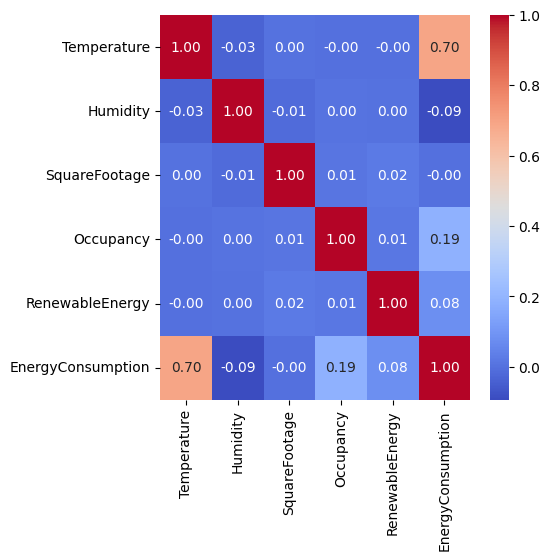

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Timestamp          1000 non-null   datetime64[ns]
 1   Temperature        1000 non-null   float64       
 2   Humidity           1000 non-null   float64       
 3   SquareFootage      1000 non-null   float64       
 4   Occupancy          1000 non-null   int64         
 5   HVACUsage          1000 non-null   object        
 6   LightingUsage      1000 non-null   object        
 7   RenewableEnergy    1000 non-null   float64       
 8   DayOfWeek          1000 non-null   object        
 9   EnergyConsumption  1000 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 78.3+ KB


<Figure size 640x480 with 0 Axes>

In [10]:


#correlation analysis
# %%
numeric_data = data.select_dtypes(include=["int64", "float64"]).columns
corr = data[numeric_data].corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr, annot= True, cmap="coolwarm", fmt = ".2f", cbar = True, linewidths = 0)
plt.show()
plt.savefig("correlation_matrix.png", dpi = 300, bbox_inches = "tight")

# there is a strong correlation for of Temperature with Energyconsumption
# %%

data.info()

In [11]:

# Dealing with categorical Data
# ANOVA Test for the categorical variables. 
# NO need to normalize the energyconsumption when using ANOVA

import pandas as pd
from scipy import stats

X = data[["HVACUsage","LightingUsage", "DayOfWeek"]]
y = data["EnergyConsumption"]

#apply ANOVA
anova_result_hvac = stats.f_oneway(y[X["HVACUsage"] == "On"], y[X["HVACUsage"] == "Off"])

print("ANOVA result for HVACusage (On vs Off)")
print(f"F-statistics, {anova_result_hvac.statistic:.5f}")
print(f"F-statistics, {anova_result_hvac.pvalue:.5f}")


#apply ANOVA
anova_result_Lighting = stats.f_oneway(y[X["LightingUsage"] == "On"], y[X["LightingUsage"] == "Off"])

print("ANOVA result for LightingUsage (On vs Off)")
print(f"F-statistics, {anova_result_Lighting.statistic:.5f}")
print(f"F-statistics, {anova_result_Lighting.pvalue:.5f}")


#apply ANOVA on DayOfWeek

#apply ANOVA
anova_result_day = stats.f_oneway(y[X["DayOfWeek"] == "Monday"], y[X["DayOfWeek"] == "Tuesday"], y[X["DayOfWeek"] == "Wednesday"],
                                       y[X["DayOfWeek"] == "Thursday"], y[X["DayOfWeek"] == "Friday"], y[X["DayOfWeek"] == "Saturday"],
                                       y[X["DayOfWeek"] == "Sunday"])
                                      

print("ANOVA result for LightingUsage (On vs Off)")
print(f"F-statistics, {anova_result_day.statistic:.5f}")
print(f"F-statistics, {anova_result_day.pvalue:.5f}")


ANOVA result for HVACusage (On vs Off)
F-statistics, 89.21920
F-statistics, 0.00000
ANOVA result for LightingUsage (On vs Off)
F-statistics, 8.78716
F-statistics, 0.00311
ANOVA result for LightingUsage (On vs Off)
F-statistics, 0.31565
F-statistics, 0.92902


- Mean EnergyConsumption for HVACUsage ON is significantly different to those with HVACUsage Off
- Mean EnergyConsumption for Lighting ON is significantly different to those with Lighting Off
- Mean EnergyConsumption does not differ accross differend days of week

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Timestamp          1000 non-null   datetime64[ns]
 1   Temperature        1000 non-null   float64       
 2   Humidity           1000 non-null   float64       
 3   SquareFootage      1000 non-null   float64       
 4   Occupancy          1000 non-null   int64         
 5   HVACUsage          1000 non-null   object        
 6   LightingUsage      1000 non-null   object        
 7   RenewableEnergy    1000 non-null   float64       
 8   DayOfWeek          1000 non-null   object        
 9   EnergyConsumption  1000 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 78.3+ KB


### Outlier Detection 

##  Time series Visualizations

Text(0.5, 1.0, 'Energy Consumption over the whole dataset')

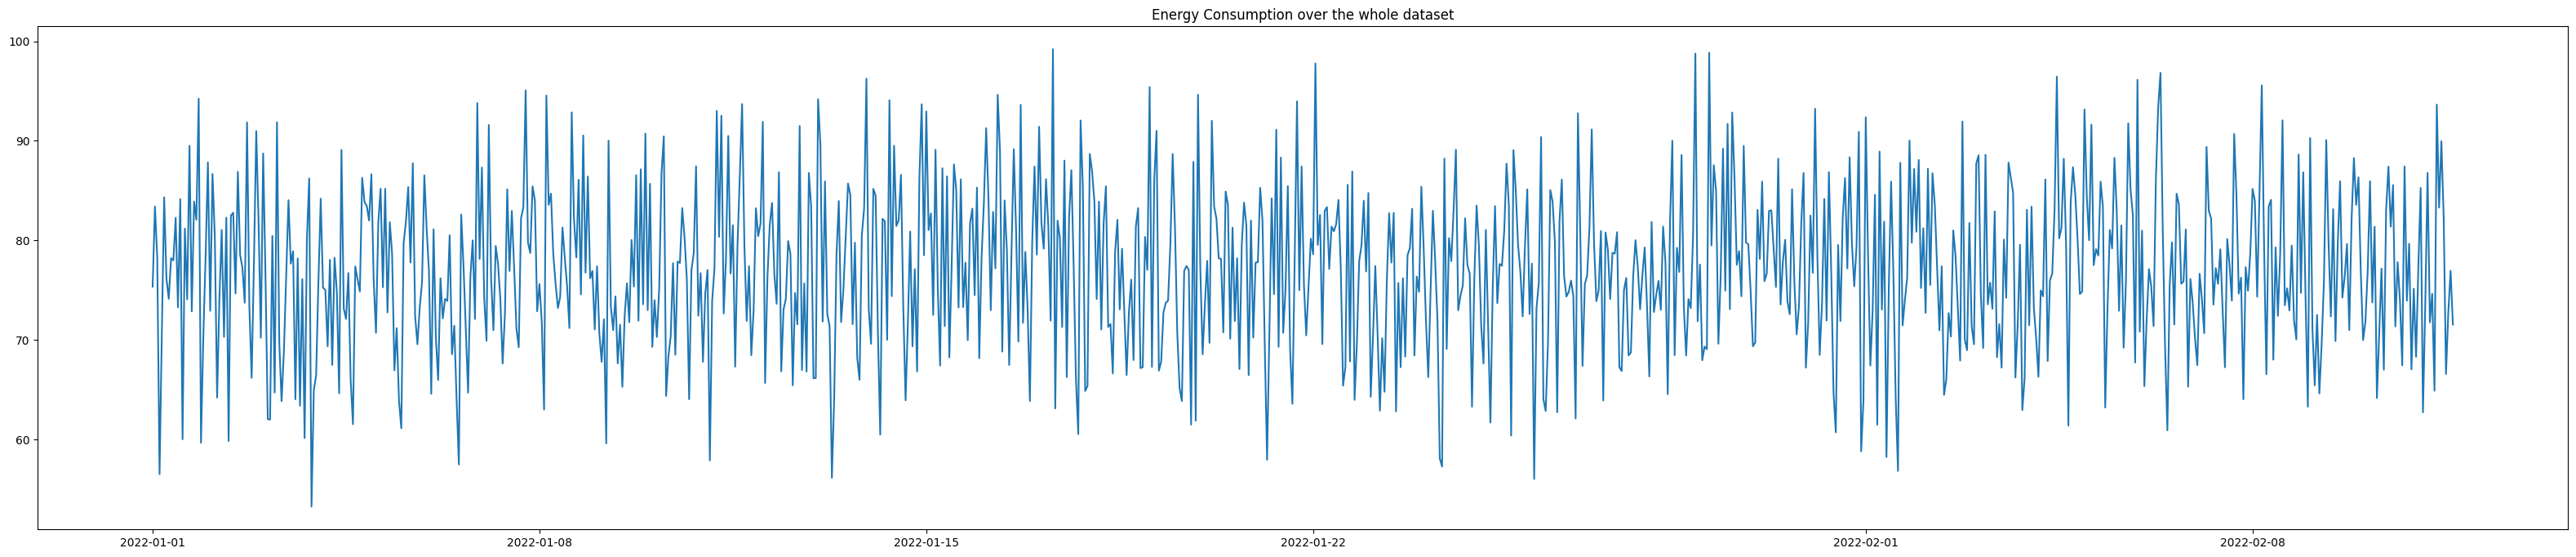

In [13]:
from datetime import datetime
import matplotlib.pyplot as plt
import datetime
import numpy as np

# for this use the data without indexation of the datetime: 

#data["Timestamp"] = pd.to_datetime(data["Timestamp"])

data = data.sort_values("Timestamp")

plt.figure(figsize = (40,8))

plt.plot(data["Timestamp"], data["EnergyConsumption"])
plt.title("Energy Consumption over the whole dataset")

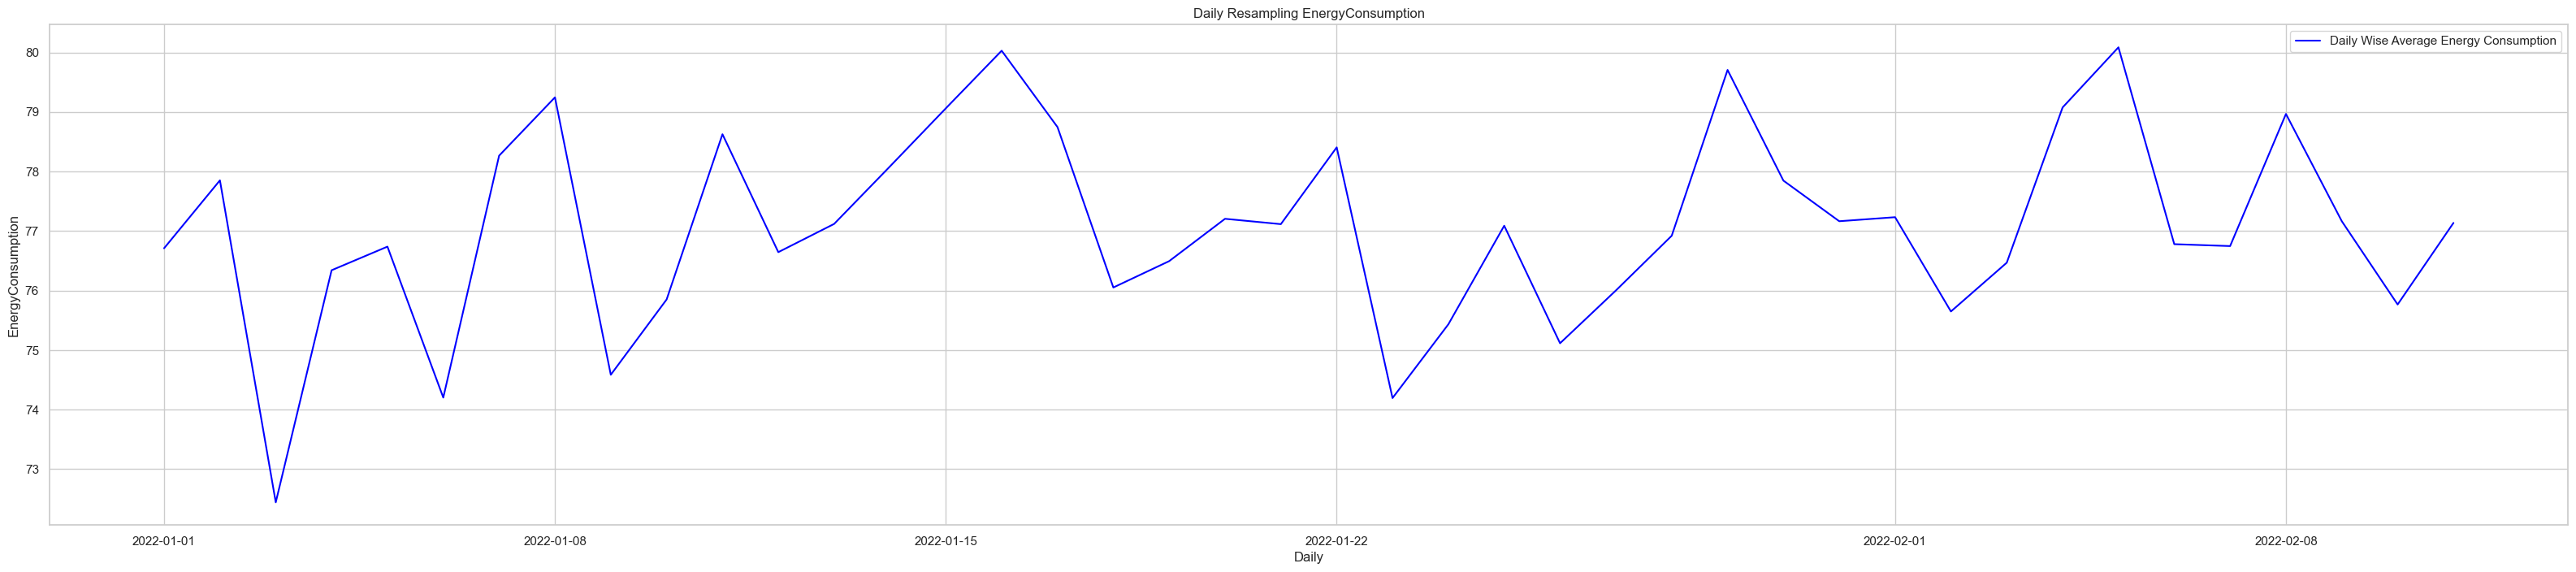

In [14]:
# Resampling per daily

#resample to daily frequency

df_resampled = data_date_indexed.resample("D").mean(numeric_only=True)
sns.set(style="whitegrid")

plt.figure(figsize=(40,8))
sns.lineplot(data = df_resampled, x = df_resampled.index, y = "EnergyConsumption", label = "Daily Wise Average Energy Consumption", color = "blue")

plt.xlabel("Daily")
plt.ylabel("EnergyConsumption")
plt.title("Daily Resampling EnergyConsumption")

plt.show()



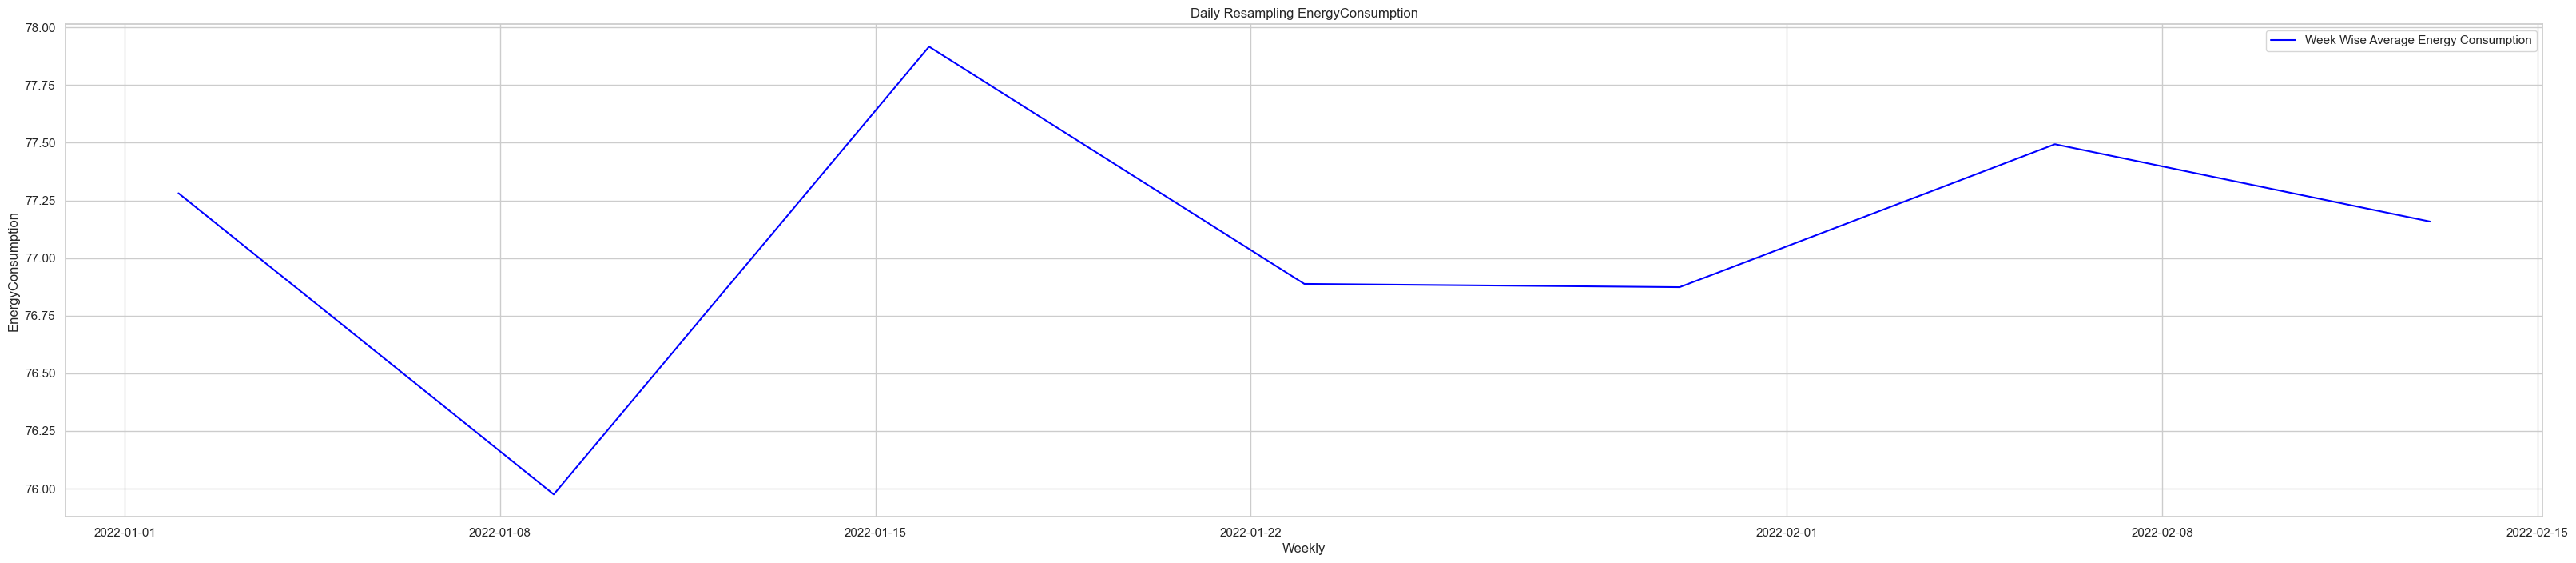

In [15]:
# Resampling per week

#resample to weekly frequency

df_resampled = data_date_indexed.resample("W").mean(numeric_only=True)
sns.set(style="whitegrid")

plt.figure(figsize=(40,8))
sns.lineplot(data = df_resampled, x = df_resampled.index, y = "EnergyConsumption", label = "Week Wise Average Energy Consumption", color = "blue")

plt.xlabel("Weekly")
plt.ylabel("EnergyConsumption")
plt.title("Daily Resampling EnergyConsumption")

plt.show()



<Figure size 1200x600 with 0 Axes>

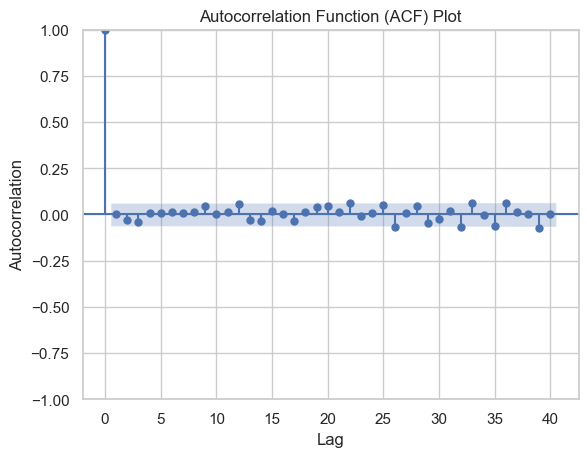

In [16]:
#Detecting seasonality using Auto correlation: 

# Plot the ACF
plt.figure(figsize=(12, 6))
plot_acf(data_date_indexed['EnergyConsumption'], lags=40) # You can adjust the number of lags as needed
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()




Detecting stationarity:

- use ADF test:
- The test is based on the;

    -   Null hypothesis that a unit root is present in the time series, indicating that the series is non-stationary.
    -   The alternative hypothesis is that the series is stationary after differencing (i.e., it has no unit root).
- The ADF test employs an augmented regression model that includes lagged differences of the series to determine the presence of a unit root.

- if p > the process in not stationary
- if p = 0.0, the process is stationary. 


In [17]:
from statsmodels.tsa.stattools import adfuller


result = adfuller(data_date_indexed['EnergyConsumption'])
print(result)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4]) 

(np.float64(-31.576934146718358), 0.0, 0, 999, {'1%': np.float64(-3.4369127451400474), '5%': np.float64(-2.864437475834273), '10%': np.float64(-2.568312754566378)}, np.float64(6868.541335798459))
ADF Statistic: -31.576934146718358
p-value: 0.0
Critical Values: {'1%': np.float64(-3.4369127451400474), '5%': np.float64(-2.864437475834273), '10%': np.float64(-2.568312754566378)}


Summary for the stationarity: according to what I undestood, the data for the energy consumption is not stationary. "Based on the ADF Statistici.e > all Critical Values, So, we accept the null hypothesis and conclude that the data does not appear to be stationary according to the Augmented Dickey-Fuller test.
This suggests that differencing or other transformations may be needed to achieve stationarity before applying certain time series models."

KeyError: 'EnergyConsumption_diff'

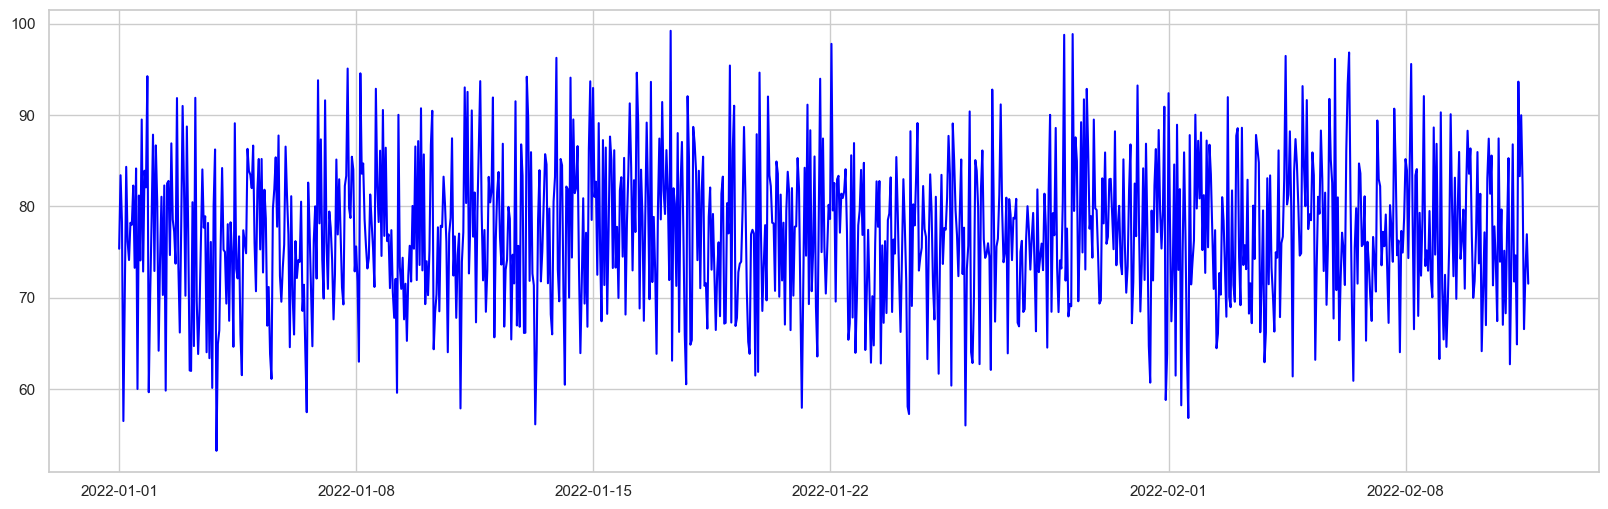

In [18]:
# Differencing: involves subtracting the previous observation from the current observation to remove trends or seasonality.

# Differencing: involves subtracting the previous observation from the current observation to remove trends or seasonality.

data_date_indexed['EnergyConsumption_diff'] = data_date_indexed['EnergyConsumption'].diff()

# Plotting
plt.figure(figsize=(20, 6))
plt.plot(data["Timestamp"], data['EnergyConsumption'], label='Original EnergyConsumption', color='blue')
plt.plot(data["Timestamp"], data['EnergyConsumption_diff'], label='Differenced EnergyConsumption', linestyle='--', color='green')
plt.legend()
plt.title('Original vs Differenced EnergyConsumption')
plt.show()

Differencing operation is commonly used to transform a time series into a new series that represents the changes between consecutive observations.

Summary for the plots: 

- Trend: the trends goes up for the energy usage
- Seasonality: there is no seasonality
- Stationarity: 


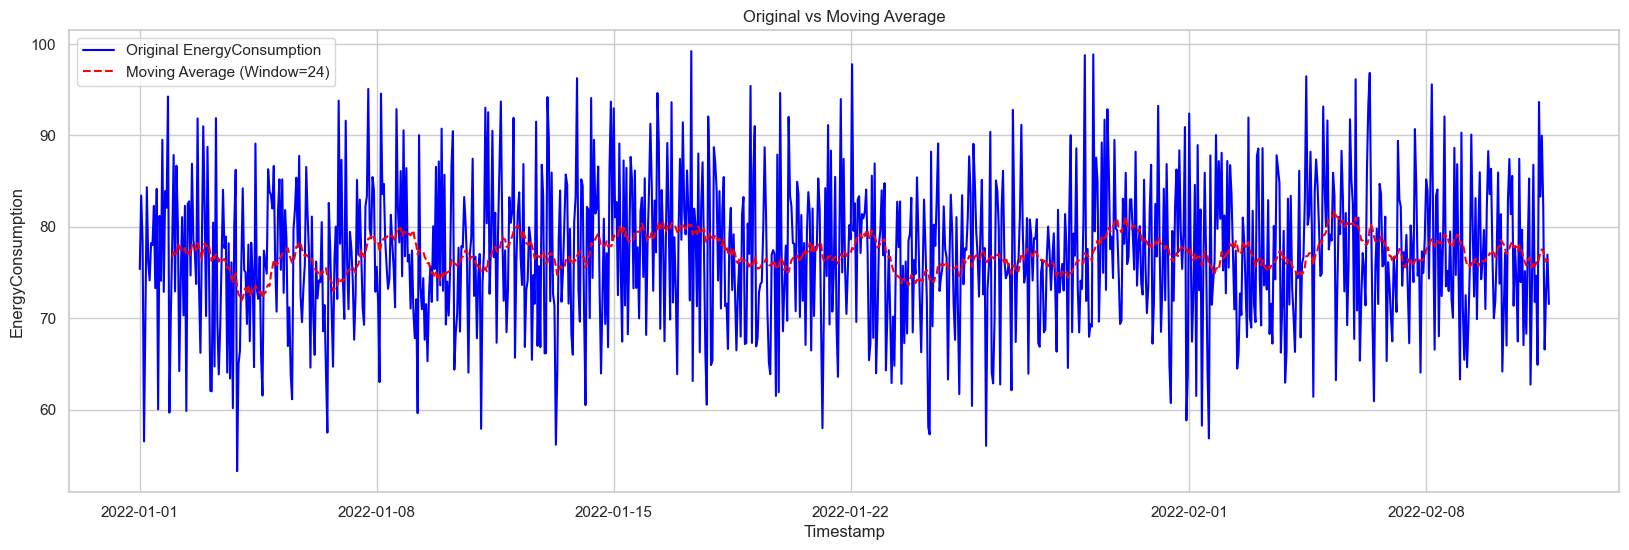

In [16]:
# Moving Average
window_size = 24
data['EnergyConsumption_smoothed'] = data['EnergyConsumption'].rolling(window=window_size).mean()

# Plotting
plt.figure(figsize=(20, 6))

plt.plot(data["Timestamp"], data['EnergyConsumption'], label='Original EnergyConsumption', color='blue')
plt.plot(data["Timestamp"], data['EnergyConsumption_smoothed'], label=f'Moving Average (Window={window_size})', linestyle='--', color='red')

plt.xlabel('Timestamp')
plt.ylabel('EnergyConsumption')
plt.title('Original vs Moving Average')
plt.legend()
plt.show()

In [95]:
#Printing the original and differenced data side by side we get;

# Create a DataFrame with 'high' and 'high_diff' columns side by side
df_combined = pd.concat([data['EnergyConsumption'], data['EnergyConsumption_diff']], axis=1)

# Display the combined DataFrame
print(df_combined.head())

   EnergyConsumption  EnergyConsumption_diff
1          83.401855                8.037482
2          78.270888               -5.130967
3          56.519850              -21.751037
4          70.811732               14.291882
5          84.321885               13.510153


In [97]:
# Remove rows with missing values
data.dropna(subset=['EnergyConsumption_diff'], inplace=True)
data['EnergyConsumption_diff'].head()

1     8.037482
2    -5.130967
3   -21.751037
4    14.291882
5    13.510153
Name: EnergyConsumption_diff, dtype: float64

In [99]:
from statsmodels.tsa.stattools import adfuller

# Assuming df is your DataFrame
result = adfuller(data['EnergyConsumption_diff'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -12.803800024126387
p-value: 6.667008105694873e-24
Critical Values: {'1%': np.float64(-3.437054035425408), '5%': np.float64(-2.8644997864059363), '10%': np.float64(-2.5683459429326576)}


# Building a model 

There are many ways to model a time series in order to make predictions. The most popular ways include:

- Moving average.
- Exponential smoothing.
- Double exponential smoothing.
- Triple exponential smoothing.
- Seasonal autoregressive integrated moving average (SARIMA.)

### Moving average
- in general is used to see trends of the data.
- the next oversvation is the mean of all past observations. 
- By changing the value of the window size you can smooth the data and maybe observe some trends. 

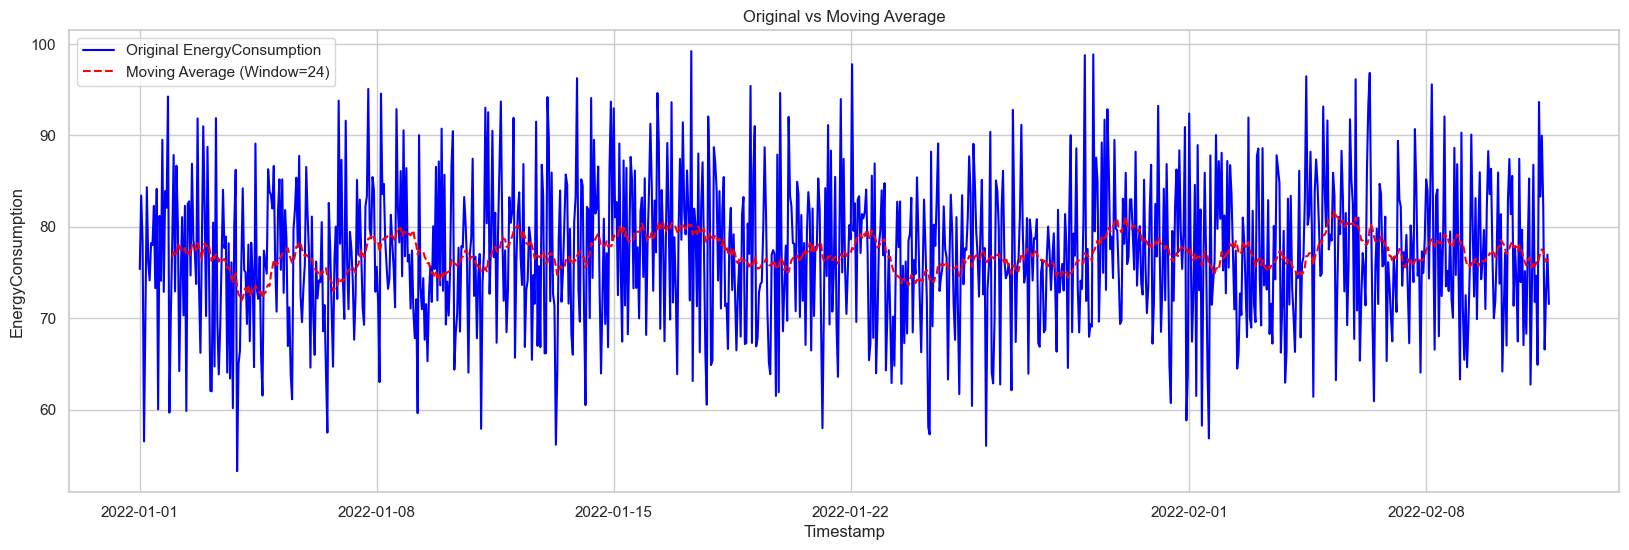

In [19]:
# Moving Average
window_size = 24
data['EnergyConsumption_smoothed'] = data['EnergyConsumption'].rolling(window=window_size).mean()

# Plotting
plt.figure(figsize=(20, 6))

plt.plot(data["Timestamp"], data['EnergyConsumption'], label='Original EnergyConsumption', color='blue')
plt.plot(data["Timestamp"], data['EnergyConsumption_smoothed'], label=f'Moving Average (Window={window_size})', linestyle='--', color='red')

plt.xlabel('Timestamp')
plt.ylabel('EnergyConsumption')
plt.title('Original vs Moving Average')
plt.legend()
plt.show()

### Exponential smoothing
- here applies the similar logic as in the moving average, except less importance is given to the next data as we move further from the present. 
- math. equation: y = AXt + (1-A)Yt-1, t > 0
    - A is a smoothing factor between 0 and 1; it determines how fast the weight decreases for the previous observations. 
    - the closer is A to zero the smoother the line will be and will approach the average. 




### Double exponential smoothing
- used when there is a trend in the time series
- exponential smoothing is used twice: 
    - math. equations: 
    y = AXt + (1-A)(Yt-1 + Bt-1)
    Bt = ß(Yt -Yt-1) + (1-ß)Bt-1
    ß: trend smoothing factor, takes value between 0 and 1
    

### Triple exponential smoothing

- This method extedns the double exponential smoothing by adding a seasonal exponential factor. 
- It is useful when we see seasonality in time series. 
- y(gamma) is the seasonal smoothing factor and L is the length of the season.

### Seasonal autoregressive Integrated Moving average Model (SARIMA)



# ARMA

#follow along the tutorial https://builtin.com/data-science/time-series-model

- ARMA model can explain the relationship of time series with both random noise (moving average) and itself at a previous step (autogregression)

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


In [101]:
plt.rcParams["figure.figsize"]  = [10,7.5]

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

- mean average percentage error (MAPE) should be calculated. 

In [39]:
data_date_indexed.head()

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,EnergyConsumption,EnergyConsumption_diff
Timestamp,,,,,,,,,,
2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,75.364373,NaN
2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,83.401855,8.037482
2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,78.270888,-5.130967
2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,56.519850,-21.751037
2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,70.811732,14.291882


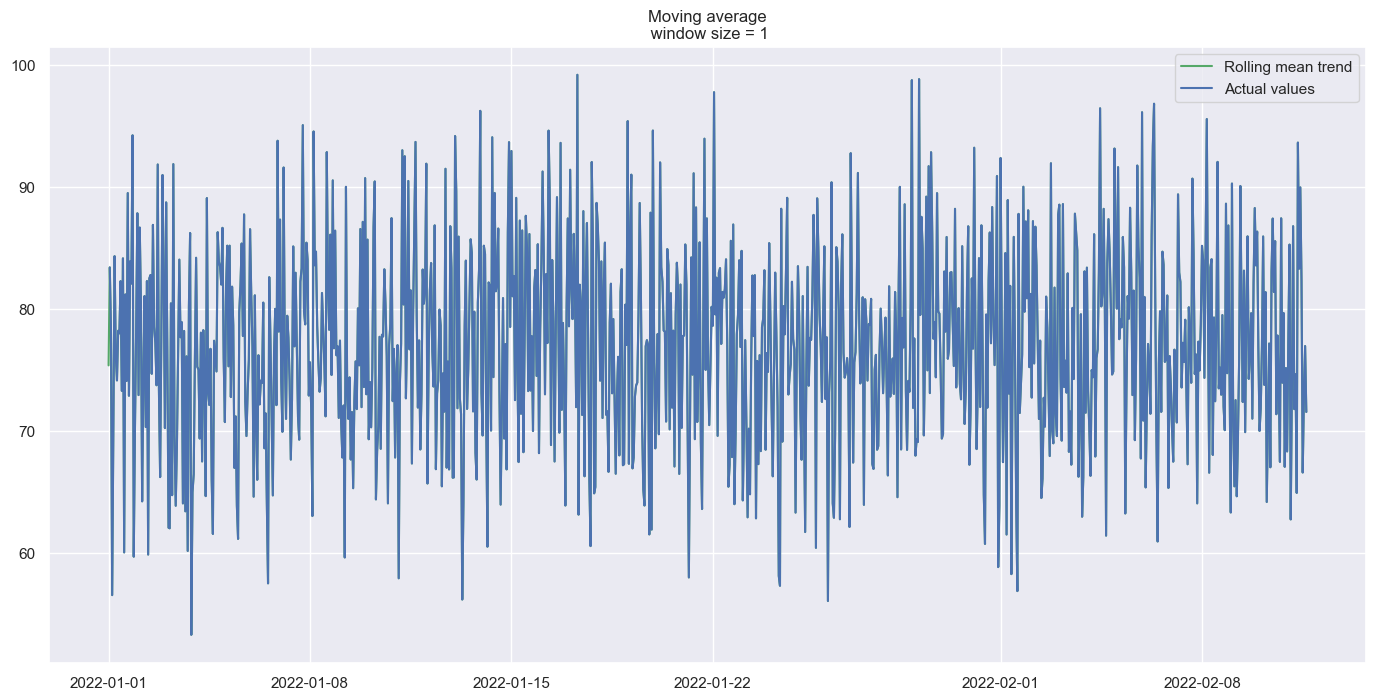

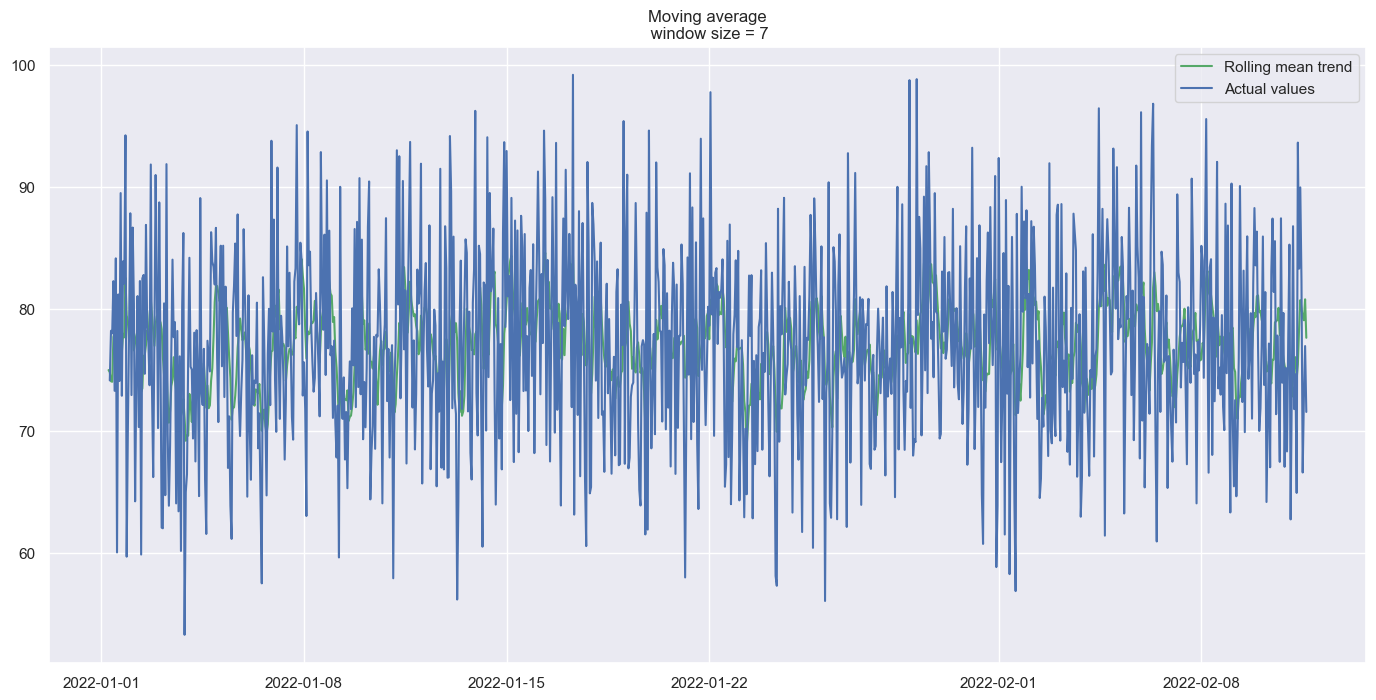

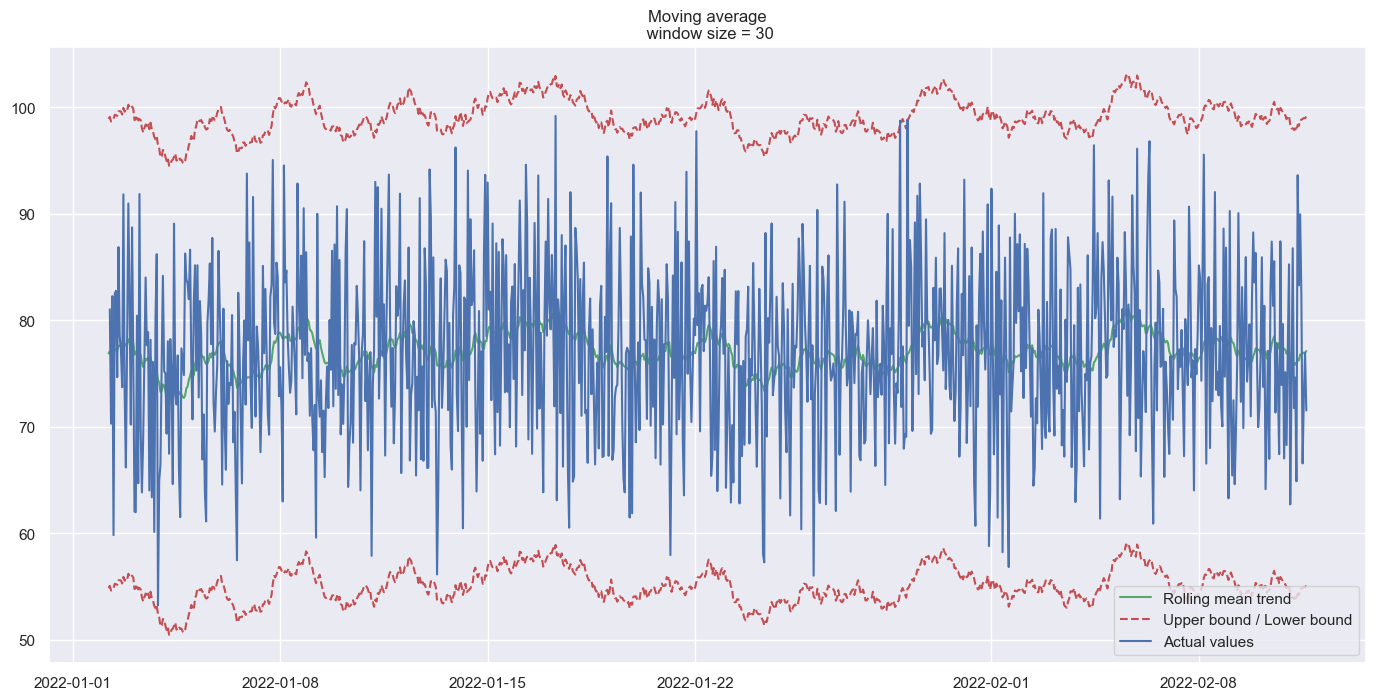

In [42]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(data_date_indexed.EnergyConsumption, 1)

#Smooth by the previous month (30 days)
plot_moving_average(data_date_indexed.EnergyConsumption, 7)

#Smooth by previous quarter (90 days)
plot_moving_average(data_date_indexed.EnergyConsumption, 30, plot_intervals=True)

### Exponential smoothing


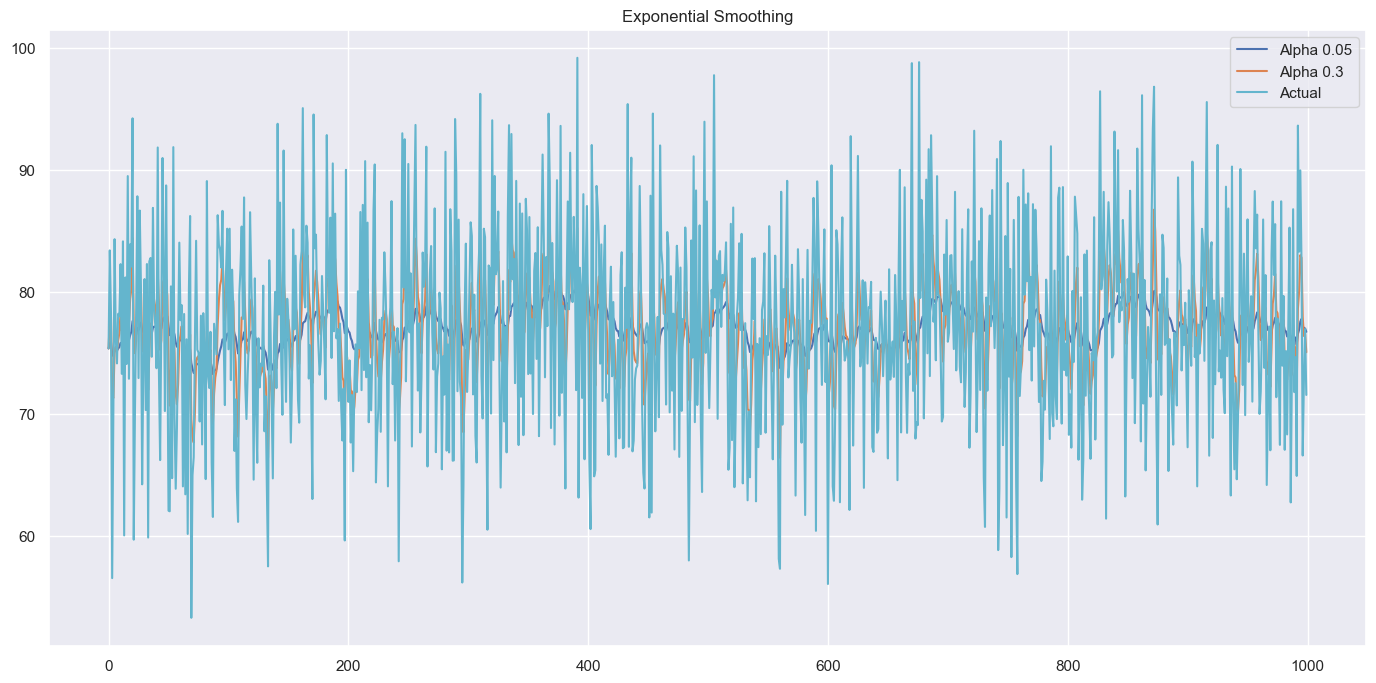

In [43]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(data_date_indexed.EnergyConsumption, [0.05, 0.3])

### Double Exponetial smoothing



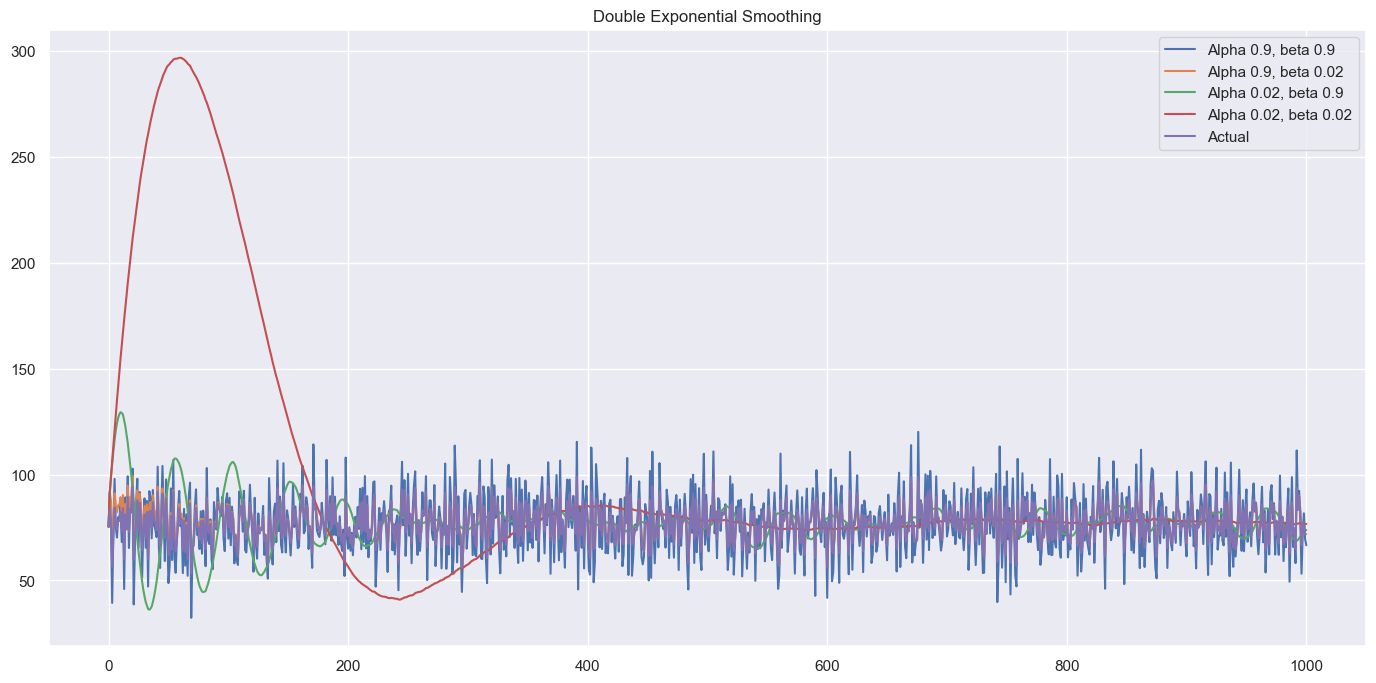

In [44]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(data_date_indexed.EnergyConsumption, alphas=[0.9, 0.02], betas=[0.9, 0.02])

### Modeling

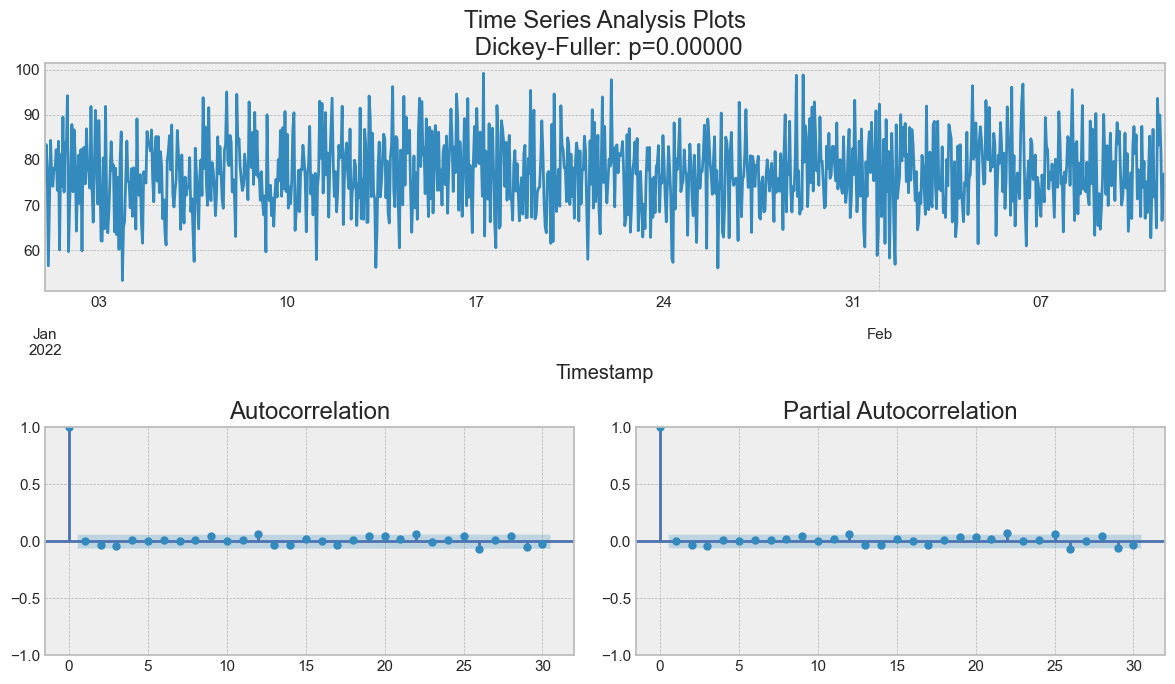

In [49]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data_date_indexed.EnergyConsumption, lags=30)

# Take the first difference to remove to make the process stationary
#data_diff = data_date_indexed.EnergyConsumption - data_date_indexed.EnergyConsumption.shift(1)

#tsplot(data_diff[1:], lags=30)

### SARIMA

In [60]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm(parameters_list):
        try: 
            model = sm.tsa.statespace.SARIMAX(data_date_indexed.EnergyConsumption, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data_date_indexed.EnergyConsumption, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

























































































































































































































































































































































































































































































































Exception ignored in: <function tqdm.__del__ at 0x105de3600>
Traceback (most recent call last):
  File "/Users/cholponzhakshylykova/Desktop/SDS/SDS-CP027-watt-wise/.venv/lib/python3.13/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/cholponzhakshylykova/Desktop/SDS/SDS-CP027-watt-wise/.venv/lib/python3.13/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attr

                                       SARIMAX Results                                        
Dep. Variable:                      EnergyConsumption   No. Observations:                 1000
Model:             SARIMAX(4, 1, 4)x(0, 1, [1, 2], 5)   Log Likelihood               -3507.001
Date:                                Fri, 09 May 2025   AIC                           7036.003
Time:                                        15:33:39   BIC                           7089.922
Sample:                                    01-01-2022   HQIC                          7056.502
                                         - 02-11-2022                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.0195      0.073    -27.749      0.000      -2.162      -1.877
ar.

In [68]:
# save the output of the summary of the model into a separate file
with open("sarima_summary.txt", "w") as summary1:
    summary1.write(str(best_model.summary()))


### Long short-term Memory (LSTM)

This is a deep learning model that can handle time seris data with long-term dependencies

In [ ]:



# Check for missing or duplicated timestamps
missing_timestamps = data['Timestamp'].isnull().sum()
duplicated_timestamps = data['Timestamp'].duplicated().sum()

print(f"Missing timestamps: {missing_timestamps}")
print(f"Duplicated timestamps: {duplicated_timestamps}")

# Ensure timestamps are properly formatted and consistent
try:
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    print("Timestamps are properly formatted.")
except Exception as e:
    print(f"Error in timestamp formatting: {e}")


In [ ]:
# Welcome to the SuperDataScience Community Project!

Welcome to the **Watt Wise: Intelligent Time Series Energy Consumption Forecasting** repository! 🎉

This project is a collaborative initiative brought to you by SuperDataScience, a thriving community dedicated to advancing the fields of data science, machine learning, and AI. We are excited to have you join us in this journey of learning, experimentation, and growth.

To contribute to this project, please follow the guidelines available in our [CONTRIBUTING.md](CONTRIBUTING.md) file.

# Project Scope of Works:

## Project Overview
**Watt Wise** is a time series forecasting project aimed at predicting and analyzing building energy usage using data on temperature, humidity, occupancy, and operational factors such as HVAC and lighting usage. By leveraging temporal modeling techniques, this project will address seasonality, trends, and other time-dependent patterns in energy consumption.

Dataset: [Energy Consumption Prediction](https://www.kaggle.com/datasets/mrsimple07/energy-consumption-prediction)

## Project Objectives
- Timeseries analysis of historical data and analysis of trends
- Develop advanced timeseries models which fit the current data
- Deploy the model to production via a cloud service

## Workflow

### **Phase 1: Setup (1 Week)**
- Setup GitHub repo and project folders
- Setup virtual environment and respective libraries

### **Phase 2: EDA (1 Week)**
- **Data Integrity Check**
    - Load dataset; ensure timestamps are properly formatted and consistent.
    - Identify any missing or duplicated timestamps.

- **Time Series Profiling**
    - Assess data continuity and frequency of timestamps.
    - Explore seasonality, trends, and anomalies in the energy consumption over time.

- **Feature Exploration & Engineering**
    - Investigate temperature, humidity, occupancy, HVAC, lighting usage, and renewable energy over time.
    - Create time-lagged features (e.g., last-hour consumption), rolling means, or day-of-week indicators to capture temporal patterns.

- **Time Series Visualization**
    - Plot consumption trends (daily, weekly, monthly).
    - Identify peaks or dips in consumption relative to HVAC, lighting, holiday, and occupancy changes.

- **Data Preprocessing & Feature Engineering**
    - Fill or interpolate missing time periods where appropriate.
    - Create lagged features, rolling statistics, day-of-week or holiday encodings.
    - Examine potential transformations (log or Box-Cox) if needed to stabilize variance.

### **Phase 3: Model Development (2 Weeks)**
1. **Baseline & Classical Models**
    - Implement naive or moving average baseline forecasts.
    - Build ARIMA/SARIMA or similar statistical models, incorporating exogenous variables (HVAC usage, occupancy, etc.).

2. **Machine Learning/Deep Learning Approaches** (optional)
    - Evaluate hybrid methods using scikit-learn or XGBoost with time-based splitting.
    - Test LSTM/GRU neural networks if you have enough data and want advanced modeling.

3. **Hyperparameter Tuning & Evaluation**
    - Leverage time series cross-validation.
    - Compare performance via RMSE, MAE, MAPE, and R².
    - Select the best-performing model based on accuracy, forecast stability, and interpretability.

### **Phase 4: Deployment (1 Week)**
- **Streamlit App Creation**
    - **Forecast Feature**: Users can select a timeframe to predict (next 24 hours, next 7 days, etc.).
    - **Visualization Dashboards**: Provide interactive charts of historical trends and forecast intervals.

- **Hosting & Documentation**
    - Deploy the app on Streamlit Community Cloud or equivalent.
    - Include README or user guide in the GitHub repository for easy onboarding.

## Timeline

| Phase                          | Task                                                                     | Duration    |
| ------------------------------ | ------------------------------------------------------------------------ | ----------- |
| **Phase 1: Setup**             | Repository setup, environment installation, data integrity check         | Week 1      |
| **Phase 2: Time Series EDA**   | EDA, feature engineering, examining correlations and time-based patterns | Week 2      |
| **Phase 3: Model Development** | Baseline & ARIMA-class models, machine learning / deep learning, tuning  | Weeks 3 & 4 |
| **Phase 4: Deployment**        | Streamlit app build, hosting, documentation                              | Week 5      |